# Baseline
- Updated 2023.05.09
- Written by shyeon

## Preparing to run the code

In [1]:
import os
from pathlib import Path

curr_path = Path().absolute()
os.chdir(curr_path.parent)  # change working directory to parent path

In [2]:
import pickle
from itertools import combinations

import lightgbm as lgb
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from networkx.exception import NetworkXError
from pyvis.network import Network
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from src.utils.logger import get_logger

logger = get_logger()
random_seed = 42

## Loading & processing dataset

In [3]:
value_df = pd.read_pickle("data/processed/values.pickle")

test_items = value_df.columns.tolist()
item_2_idx = {v: k for k, v in enumerate(test_items)}
idx_2_item = {k: v for k, v in enumerate(test_items)}

- scaling using standard scaler
- divide into train & test dataset

In [4]:
train, test = train_test_split(value_df, test_size=0.5, random_state=random_seed, shuffle=False)
scaler = StandardScaler().fit(train)
# scaled_train = pd.DataFrame(scaler.transform(train), columns=train.columns)
# scaled_test = pd.DataFrame(scaler.transform(test), columns=test.columns)
scaled_train = pd.DataFrame(scaler.transform(train))
scaled_test = pd.DataFrame(scaler.transform(test))
titles = train.columns.tolist()

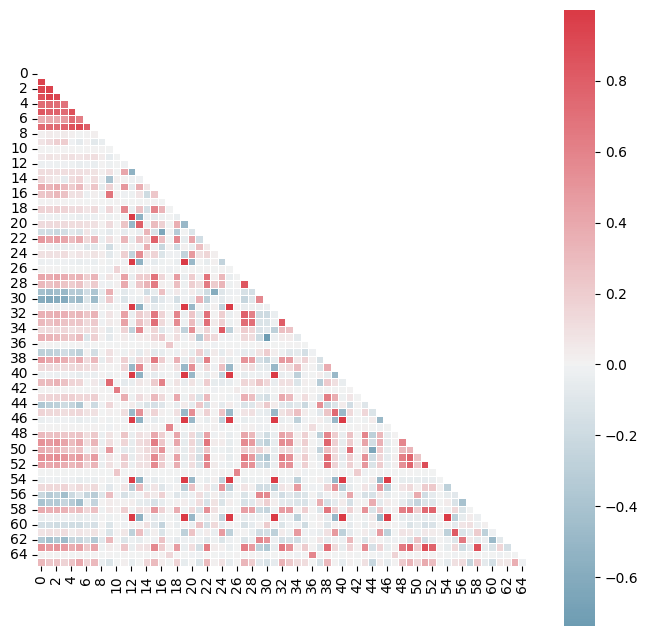

In [5]:
def corr_graph(matrix: np.array):
    mask = np.triu(np.ones_like(matrix, dtype=bool))  # 역 삼각 모양 마스크
    f, ax = plt.subplots(figsize=(8, 8))
    cmap = sns.diverging_palette(230, 10, as_cmap=True)
    sns.heatmap(matrix, mask=mask, cmap=cmap, center=0, square=True, linewidths=0.5)

train_corr = scaled_train.corr()
train_corr = np.corrcoef(scaled_train.values, rowvar=False)
corr_graph(train_corr) # visualization

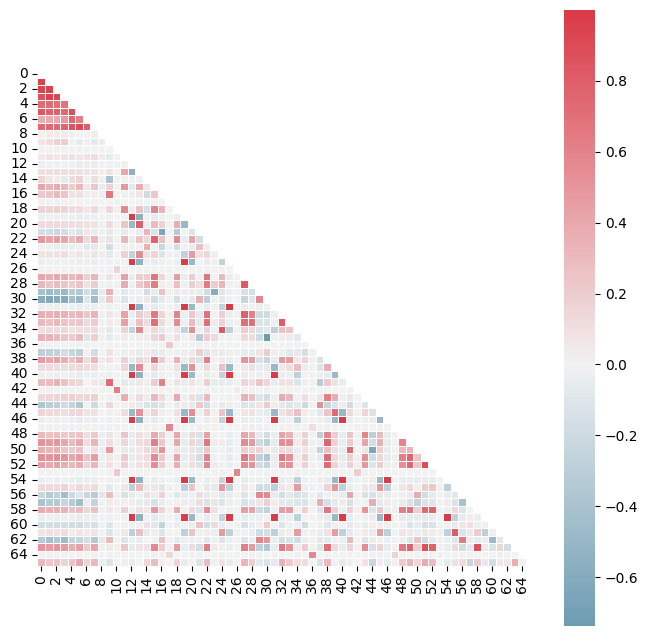

In [6]:
train_corr = scaled_train.corr()
corr_graph(train_corr) # visualization

## Rank feature importance
- make graph instance using Networkx

In [7]:
def build_nx_graph(
    corr_mat: pd.DataFrame,
    titles: list[str],
    pos: pd.DataFrame | None = None,
    highlights: list[str] | None = None,
    threshold: float = 0.0,
) -> nx.Graph:
    """Build a graph using Python's NetworkX library

    Args:
        corr_mat (pd.DataFrame): A matrix representing the correlation values between paired nodes
        titles (list[str]): Node titles
        pos (pd.DataFrame | None, optional): Location of nodes in a graph. Defaults to None.
        highlights (list[str] | None, optional): Highlighted node with a specific color. Defaults to None.
        threshold (float, optional): _description_. Defaults to 0.0.

    Returns:
        nx.Graph: a directed graph with the NetworkX library
            to model the relationships between nodes in RF test items
    """

    G = nx.Graph()
    for i, title in enumerate(titles):
        G.add_node(i, label=f"Node {i}", title=title)
    for n1, n2 in combinations(G.nodes, 2):
        if abs(corr_mat.loc[n1, n2]) < threshold:  # there is no edges btw node1 and node2
            continue
        G.add_edges_from([(n1, n2, {"value": abs(corr_mat.loc[n1, n2])})])
    if pos is not None:
        assert G.number_of_nodes() == len(pos)
        for index, (x, y) in pos.iterrows():
            G.nodes[index]["x"], G.nodes[index]["y"] = x, y
    if highlights is not None:
        for node in highlights:
            G.nodes[node]["color"] = "#dd4b39"
    return G.to_directed()

In [8]:
pos = pd.read_csv("data/processed/position.csv", index_col="node")  # position of nodes
G = build_nx_graph(train_corr, titles, pos=pos, threshold=0.6)

- Visualization using pyvis

In [9]:
net = Network("1500px", "1500px")
net.force_atlas_2based()
net.from_nx(G)

- PageRank

In [10]:
def pagerank(
    G,
    alpha=0.85,
    personalization=None,
    max_iter=100,
    tol=1.0e-6,
    nstart=None,
    weight="weight",
    dangling=None,
):
    """Return the PageRank of the nodes in the graph.
    PageRank computes a ranking of the nodes in the graph G based on
    the structure of the incoming links. It was originally designed as
    an algorithm to rank web pages.
    Parameters
    ----------
    G : graph
        A NetworkX graph.  Undirected graphs will be converted to a directed
        graph with two directed edges for each undirected edge.
    alpha : float, optional
        Damping parameter for PageRank, default=0.85.
    personalization: dict, optional
        The "personalization vector" consisting of a dictionary with a
        key for every graph node and nonzero personalization value for each node.
        By default, a uniform distribution is used.
    max_iter : integer, optional
        Maximum number of iterations in power method eigenvalue solver.
    tol : float, optional
        Error tolerance used to check convergence in power method solver.
    nstart : dictionary, optional
        Starting value of PageRank iteration for each node.
    weight : key, optional
        Edge data key to use as weight.  If None weights are set to 1.
    dangling: dict, optional
        The outedges to be assigned to any "dangling" nodes, i.e., nodes without
        any outedges. The dict key is the node the outedge points to and the dict
        value is the weight of that outedge. By default, dangling nodes are given
        outedges according to the personalization vector (uniform if not
        specified). This must be selected to result in an irreducible transition
        matrix (see notes under google_matrix). It may be common to have the
        dangling dict to be the same as the personalization dict.
    Returns
    -------
    pagerank : dictionary
        Dictionary of nodes with PageRank as value
    Notes
    -----
    The eigenvector calculation is done by the power iteration method
    and has no guarantee of convergence.  The iteration will stop
    after max_iter iterations or an error tolerance of
    number_of_nodes(G)*tol has been reached.
    The PageRank algorithm was designed for directed graphs but this
    algorithm does not check if the input graph is directed and will
    execute on undirected graphs by converting each edge in the
    directed graph to two edges.
    """
    if len(G) == 0:
        return {}
    if not G.is_directed():
        D = G.to_directed()
    else:
        D = G
    # Create a copy in (right) stochastic form
    W = nx.stochastic_graph(D, weight=weight)
    N = W.number_of_nodes()
    # Choose fixed starting vector if not given
    if nstart is None:
        x = dict.fromkeys(W, 1.0 / N)
    else:
        # Normalized nstart vector
        s = float(sum(nstart.values()))
        x = dict((k, v / s) for k, v in nstart.items())
    if personalization is None:
        # Assign uniform personalization vector if not given
        personal_weights = dict.fromkeys(W, 1.0 / N)
    else:
        missing = set(G) - set(personalization)
        if missing:
            raise NetworkXError(
                "Personalization dictionary "
                "must have a value for every node. "
                "Missing nodes %s" % missing
            )
        s = float(sum(personalization.values()))
        personal_weights = dict((k, v / s) for k, v in personalization.items())
    if dangling is None:
        # Use personalization vector if dangling vector not specified
        dangling_weights = personal_weights
    else:
        missing = set(G) - set(dangling)
        if missing:
            raise NetworkXError(
                "Dangling node dictionary "
                "must have a value for every node. "
                "Missing nodes %s" % missing
            )
        s = float(sum(dangling.values()))
        dangling_weights = dict((k, v / s) for k, v in dangling.items())
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]
    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
        for n in x:
            # this matrix multiply looks odd because it is
            # doing a left multiply x^T=xlast^T*W
            for nbr in W[n]:
                x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * personal_weights[n]
        # check convergence, l1 norm
        err = sum([abs(x[n] - xlast[n]) for n in x])
        if err < N * tol:
            return x
    raise NetworkXError(
        "pagerank: power iteration failed to converge " "in %d iterations." % max_iter
    )

In [13]:
alpha = 0.1
pr_score = pagerank(G, alpha=alpha, weight="value")
sorted_feature_by_importance = pd.Series(pr_score).sort_values(ascending=False).index.tolist()
for node in sorted_feature_by_importance[:5]:
    print(node, pr_score[node])

13 0.01703217146432723
30 0.017002732066413218
16 0.01674152946738461
29 0.016339044315179345
51 0.01625948842193369


In [14]:
for num in range(len(sorted_feature_by_importance)):
    G = build_nx_graph(train_corr, titles, pos=pos, highlights=sorted_feature_by_importance[:num], threshold=0.5)
    net = Network("1500px", "1500px")
    net.force_atlas_2based()
    net.from_nx(G)
    net.write_html(f"data/visualization/html/nx_{alpha}_{num:02d}.html")

### Train model & evaluation

In [13]:
def predict_one(
    trainset: pd.DataFrame,
    testset: pd.DataFrame,
    xs: list[str],
    y: str,
    random_seed: int = 42,
) -> float:
    x_train, y_train = trainset[xs].values, trainset[y].values
    x_test, y_test = testset[xs].values, testset[y].values
    model = lgb.LGBMRegressor(random_state=random_seed)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return mean_squared_error(y_test, y_pred)

In [14]:
def predict_all(trainset: pd.DataFrame, testset: pd.DataFrame, rank: pd.Series, start_num: int, step: int) -> list[tuple]:
    eval_mat = []
    for num_ft in range(start_num, len(trainset.columns), step):
        logger.info(f"current loop: {num_ft}")
        xs = rank[:num_ft]
        ys = rank[num_ft:]
        scores = [predict_one(trainset, testset, xs, y) for y in ys]
        eval_mat.append((num_ft, np.mean(scores), max(scores), min(scores)))
    return eval_mat

In [15]:
eval_mat = predict_all(scaled_train, scaled_test, sorted_feature_by_importance[::-1], start_num=1, step=2)

2023-03-11 07:53:12.923 | INFO     | __main__:predict_all:4 - current loop: 1
2023-03-11 07:53:19.053 | INFO     | __main__:predict_all:4 - current loop: 3
2023-03-11 07:53:29.488 | INFO     | __main__:predict_all:4 - current loop: 5
2023-03-11 07:53:51.628 | INFO     | __main__:predict_all:4 - current loop: 7
2023-03-11 07:55:49.016 | INFO     | __main__:predict_all:4 - current loop: 9
2023-03-11 07:55:59.830 | INFO     | __main__:predict_all:4 - current loop: 11
2023-03-11 07:56:11.626 | INFO     | __main__:predict_all:4 - current loop: 13
2023-03-11 07:56:23.880 | INFO     | __main__:predict_all:4 - current loop: 15
2023-03-11 07:56:33.818 | INFO     | __main__:predict_all:4 - current loop: 17
2023-03-11 07:56:45.352 | INFO     | __main__:predict_all:4 - current loop: 19
2023-03-11 07:56:57.011 | INFO     | __main__:predict_all:4 - current loop: 21
2023-03-11 07:57:08.434 | INFO     | __main__:predict_all:4 - current loop: 23
2023-03-11 07:57:19.721 | INFO     | __main__:predict_all

In [16]:
eval_mat_df = pd.DataFrame().from_records(eval_mat, columns=["NUM_FEATURES", "MEAN", "MAX", "MIN"])
eval_mat_df = eval_mat_df.set_index("NUM_FEATURES")

<AxesSubplot: xlabel='NUM_FEATURES'>

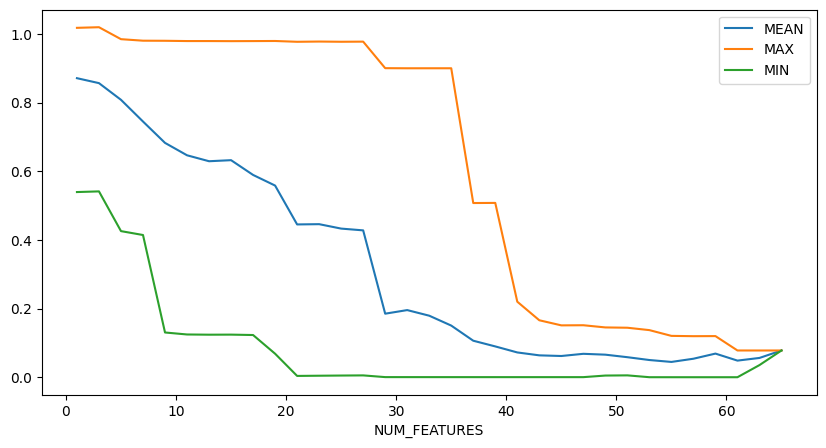

In [17]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
eval_mat_df.plot(ax=ax)

<AxesSubplot: xlabel='NUM_FEATURES'>

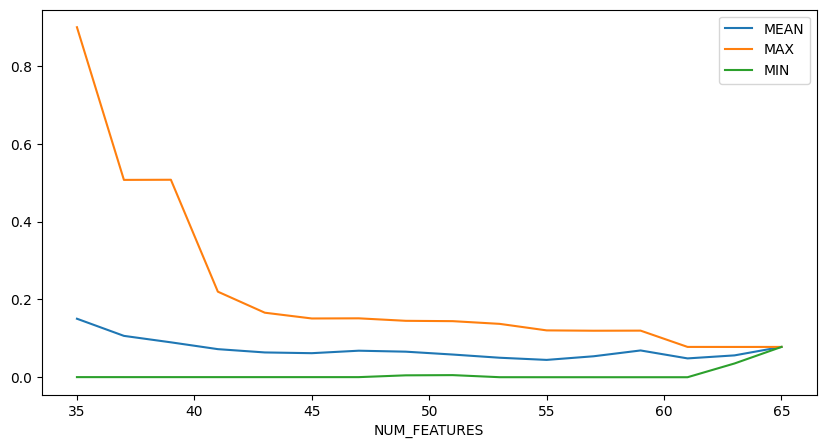

In [18]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
eval_mat_df.loc[35:, :].plot(ax=ax)